# DataFlowTasks.jl


`DataFlowTasks.jl` is a Julia package dedicated to parallel programming on
multi-core shared memory CPUs. From user annotations (READ, WRITE, READWRITE)
on program data, `DataFlowTasks.jl` automatically infers dependencies between
parallel tasks.

## Installation

```julia
using Pkg
Pkd.add("https://github.com/maltezfaria/DataFlowTasks.jl.git")
```

## Basic Usage

This package defines a `@dspawn` macro which behaves very much like
`Threads.@spawn`, except that it allows the user to specify explicit *data
dependencies* for the spawned `Task`. This information is then used to
automatically infer *task dependencies* by constructing and analyzing a
directed acyclic graph based on how tasks access the underlying data. The
premise is that it is sometimes simpler to specify how *tasks depend on data*
than to specify how *tasks depend on each other*.

When creating a `Task` using `@dspawn`, the following
annotations can be used to declare how the `Task` accesses the data:

- read-only: `@R` or `@READ`
- write-only: `@W` or `@WRITE`
- read-write: `@RW` or `@READWRITE`

An `@R(A)` annotation for example implies that `A` will be accessed in
read-only mode by the *task*.

Let's look at a simple example:

In [1]:
using DataFlowTasks
A = Vector{Float64}(undef, 4)
result = let
    @dspawn fill!(@W(A), 0)           # task 1: accesses everything
    @dspawn @RW(view(A, 1:2)) .+= 2   # task 2: modifies the first half
    @dspawn @RW(view(A, 3:4)) .+= 3   # task 3: modifies the second half
    @dspawn @R(A)                     # task 4: get the result
end
fetch(result)

4-element Vector{Float64}:
 2.0
 2.0
 3.0
 3.0

From annotations describing task-data dependencies, `DataFlowTasks.jl` infers
dependencies between tasks. Internally, this set of dependencies is
represented as a Directed Acyclic Graph. All the data needed to reconstruct
the `DAG` (as well as the parallalel traces) can be collected using the `@log`
macro:

In [2]:
log_info = DataFlowTasks.@log let
    @dspawn fill!(@W(A), 0)             label="write whole"
    @dspawn @RW(view(A, 1:2)) .+= 2     label="write 1:2"
    @dspawn @RW(view(A, 3:4)) .+= 3     label="write 3:4"
    res = @dspawn @R(A)                 label="read whole"
    fetch(res)
end

LogInfo with 4 logged tasks


And the DAG can be visualized using `GraphViz`:

Status `~/.julia/scratchspaces/d1549cb6-e9f4-42f8-98cc-ffc8d067ff5b/weakdeps-1.9/Project.toml`
  [13f3f980] CairoMakie v0.10.12
  [e9467ef8] GLMakie v0.8.12
  [f526b714] GraphViz v0.2.0
  [ee78f7c6] Makie v0.19.12


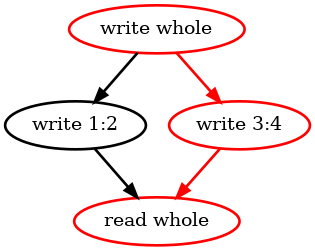

In [3]:
DataFlowTasks.stack_weakdeps_env!() # Set up a stacked environment so that weak dependencies such as GraphViz can be loaded. More about that hereafter.
using GraphViz # triggers additional code loading, powered by weak dependencies (julia >= 1.9)
dag = GraphViz.Graph(log_info)

In the example above, the tasks *write 1:2* and *write 3:4* access
different parts of the array `A` and are
therefore independent, as shown in the DAG.

## Example : Parallel Cholesky Factorization

As a less contrived example, we illustrate below the use of `DataFlowTasks` to
parallelize a tiled Cholesky factorization. The implementation shown here is
delibarately made as simple as possible.

The Cholesky factorization algorithm takes a symmetric positive definite
matrix A and finds a lower triangular matrix L such that `A = LLᵀ`. The tiled
version of this algorithm decomposes the matrix A into tiles (of even sizes,
in this simplified version). At each step of the algorithm, we do a Cholesky
factorization on the diagonal tile, use a triangular solve to update all of
the tiles at the right of the diagonal tile, and finally update all the tiles
of the submatrix with a Schur complement.

If we have a matrix A decomposed in `n x n` tiles, then the algorithm will
have `n` steps. The `i`-th step (with `i ∈ [1:n]`) will perform

- `1` Cholesky factorization of the (i,i) block,
- `(i-1)` triangular solves (one for each block in the `i`-th row),
- `i*(i-1)/2` matrix multiplications to update the submatrix.

The following image illustrates the 2nd step of the algorithm:

![](Cholesky_2ndStep.png)

A sequential tiled factorization algorithm can be implemented as:

In [4]:
using LinearAlgebra

tilerange(ti, ts) = (ti-1)*ts+1:ti*ts

function cholesky_tiled!(A, ts)
    m = size(A, 1); @assert m==size(A, 2)
    m%ts != 0 && error("Tilesize doesn't fit the matrix")
    n = m÷ts  # number of tiles in each dimension

    T = [view(A, tilerange(i, ts), tilerange(j, ts)) for i in 1:n, j in 1:n]

    for i in 1:n
        # Diagonal Cholesky serial factorization
        cholesky!(T[i,i])

        # Left blocks update
        U = UpperTriangular(T[i,i])
        for j in i+1:n
            ldiv!(U', T[i,j])
        end

        # Submatrix update
        for j in i+1:n
            for k in j:n
                mul!(T[j,k], T[i,j]', T[i,k], -1, 1)
            end
        end
    end

    # Construct the factorized object
    return Cholesky(A, 'U', zero(LinearAlgebra.BlasInt))
end

cholesky_tiled! (generic function with 1 method)

Parallelizing the code with `DataFlowTasks.jl` is as easy as wrapping function
calls within `@dspawn`, and adding annotations describing data access modes:

In [5]:
using DataFlowTasks

function cholesky_dft!(A, ts)
    m = size(A, 1); @assert m==size(A, 2)
    m%ts != 0 && error("Tilesize doesn't fit the matrix")
    n = m÷ts  # number of tiles in each dimension

    T = [view(A, tilerange(i, ts), tilerange(j, ts)) for i in 1:n, j in 1:n]

    for i in 1:n
        # Diagonal Cholesky serial factorization
        @dspawn cholesky!(@RW(T[i,i])) label="chol ($i,$i)"

        # Left blocks update
        U = UpperTriangular(T[i,i])
        for j in i+1:n
            @dspawn ldiv!(@R(U)', @RW(T[i,j])) label="ldiv ($i,$j)"
        end

        # Submatrix update
        for j in i+1:n
            for k in j:n
                @dspawn mul!(@RW(T[j,k]), @R(T[i,j])', @R(T[i,k]), -1, 1) label="schur ($j,$k)"
            end
        end
    end

    # Construct the factorized object
    r = @dspawn Cholesky(@R(A), 'U', zero(LinearAlgebra.BlasInt)) label="result"
    return fetch(r)
end

cholesky_dft! (generic function with 1 method)

(Also note how extra annotations were added in the code, in order to attach
meaningful labels to the tasks. These will later be useful to interpret the
output of debugging & profiling tools.)

The code below shows how to use this `cholesky_tiled!` function, as well as
how to profile the program and get information about how tasks were scheduled:

In [6]:
# DataFlowTasks environment setup

# Context
n  = 2048
ts = 512
A = rand(n, n)
A = (A + adjoint(A))/2
A = A + n*I;

In [7]:
println("Testing sequential Cholesky factorization")       #hide
F = cholesky_tiled!(copy(A), ts)                           #hide
                                                           #hide
# Check results                                            #hide
err = norm(F.L*F.U-A,Inf)/max(norm(A),norm(F.L*F.U))       #hide
@show err                                                  #hide
@assert err < eps(Float64)                                 #hide

Testing sequential Cholesky factorization
err = 1.96198583469625e-17


In [8]:
println("Testing parallel Cholesky factorization")         #hide

# First run to trigger compilation
F = cholesky_dft!(copy(A), ts)

# Check results
err = norm(F.L*F.U-A,Inf)/max(norm(A),norm(F.L*F.U))
@show err                   #hide
@assert err < eps(Float64)  #hide

Testing parallel Cholesky factorization
err = 1.96198583469625e-17


## Debugging and Profiling

DataFlowTasks comes with debugging and profiling tools that help
understanding how task dependencies were inferred, and how tasks were
scheduled during execution.

As usual when profiling code, it is recommended to start from a state where
all code has already been compiled, and all previous profiling information has
been discarded:

In [9]:
# Manually call GC to avoid noise from previous runs
GC.gc()

# Profile the code and return a `LogInfo` object:
log_info = DataFlowTasks.@log cholesky_dft!(A ,ts);

Visualizing the DAG can be helpful. When debugging, this representation of
dependencies between tasks as inferred by `DataFlowTasks` can help identify
missing or erroneous data dependency annotations. When profiling, identifying
the critical path (plotted in red in the DAG) can help understand the
performances of the implementation.

In this more complex example, we can see how quickly the DAG complexity
increases (even though the test case only has 4x4 blocks here):

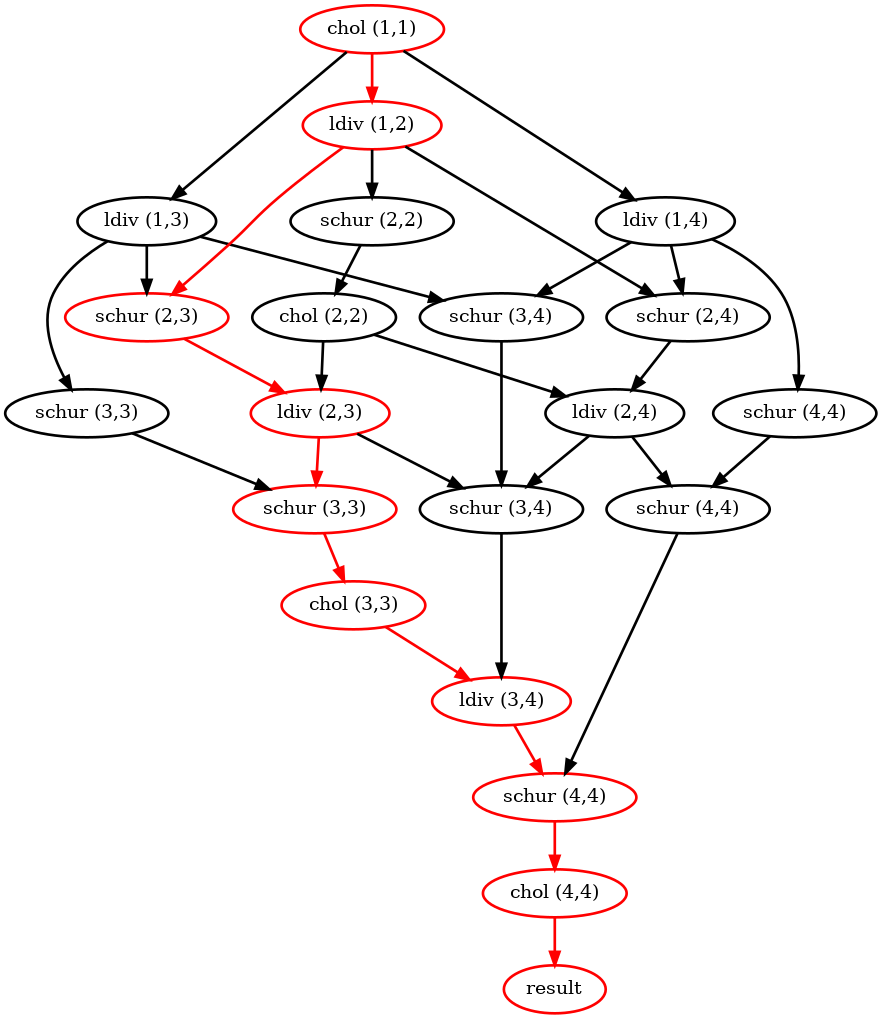

In [10]:
dag = GraphViz.Graph(log_info)

The `LogInfo` object also contains all the data needed to profile the parallel
application. A summary of the profiling information can be displayed in the
REPL using the `DataFlowTasks.describe` function:

In [11]:
DataFlowTasks.describe(log_info; categories=["chol", "ldiv", "schur"])

• Elapsed time           : 0.119
  ├─ Critical Path       : 0.118
  ╰─ No-Wait             : 0.033

• Run time               : 0.954
  ├─ Computing           :   0.260
  │  ├─ chol             :     0.033
  │  ├─ ldiv             :     0.087
  │  ├─ schur            :     0.140
  │  ╰─ unlabeled        :     0.000
  ├─ Task Insertion      :   0.000
  ╰─ Other (idle)        :   0.693


but it is often more convenient to see this information in a graphical
way. The parallel trace plot shows a timeline of the tasks execution on
available threads. It helps in understanding how tasks were scheduled. The
same window also carries other general information allowing to better
understand the performance limiting factors:

[ Info: Computing    : 0.26026795700000005
[ Info: Inserting    : 9.699000000000002e-5
[ Info: Other        : 0.6933175091655519


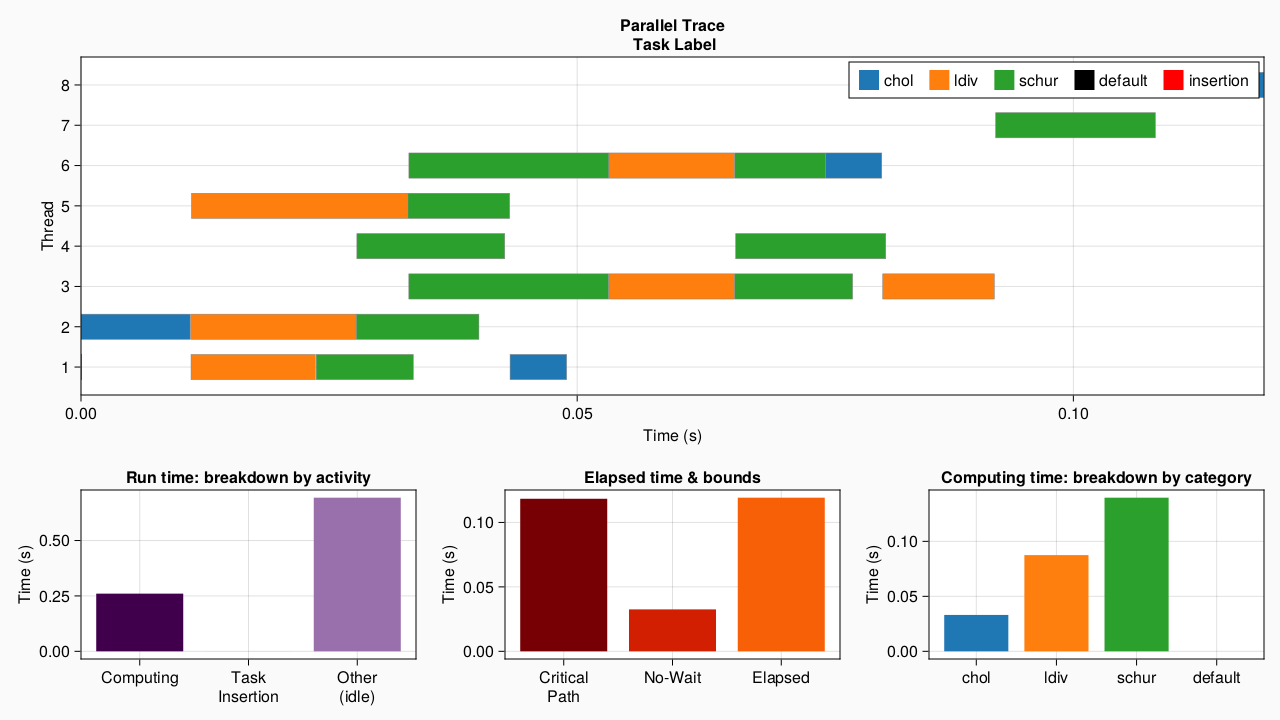

In [12]:
using CairoMakie # or GLMakie in order to have more interactivity
trace = plot(log_info; categories=["chol", "ldiv", "schur"])

We see here that the execution time is bounded by the length of the critical
path: with this block size and matrix size, the algorithm does not expose
enough parallelism to occupy all threads without waiting periods.

We'll cover in detail the usage and possibilities of the visualization in the
documentation.

Note that the debugging & profiling tools need additional dependencies such as
`Makie` and `GraphViz`, which are only meant to be used interactively during
the development process. These packages are therefore only considered as
optional dependencies; assuming they are available in your work environment,
calling e.g. `using GraphViz` will load some additional code from
`DataFlowTasks`. If these dependencies are not directly available in the
current environment stack, `DataFlowTasks.stack_weakdeps_env!()` can be called
to push to the loading stack a new environment in which these optional
dependencies are available.

## Going further: examples and performance

The [online
documentation](https://maltezfaria.github.io/DataFlowTasks.jl/dev/) contains a
variety of examples and benchmarks of applications where `DataFlowTasks` can
be used to parallelize code. These include:

- [Cholesky
  factorization](https://maltezfaria.github.io/DataFlowTasks.jl/dev/examples/cholesky/cholesky/)
- [Image
  filters](https://maltezfaria.github.io/DataFlowTasks.jl/dev/examples/blur-roberts/blur-roberts/)
- [Longest common
  subsequence](https://maltezfaria.github.io/DataFlowTasks.jl/dev/examples/lcs/lcs/)
- [Merge
sort](https://maltezfaria.github.io/DataFlowTasks.jl/dev/examples/sort/sort/)

Each example comes with a notebook version, which can be downloaded and run
locally: give it a try, and if `DataFlowTasks` is useful to you, please
consider submitting your own example application!

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*